In [1]:
# Standard Python imports
from datetime import datetime
from dateutil.tz import tzlocal
import numpy as np
import pandas as pd
%matplotlib inline

In [2]:
# Standard PyNWB imports
from pynwb.icephys import CurrentClampStimulusSeries, VoltageClampSeries
from pynwb import NWBHDF5IO

In [3]:
# Imports needed from the ndx-icephys-meta
from ndx_icephys_meta.icephys import ICEphysFile
from ndx_icephys_meta.test.test_icephys import ICEphysMetaTestBase

# 1. Create a test icephys NWB file with our new metadata tables

In [4]:
test_filename = 'test_icephys_file.h5'
nwbfile = ICEphysMetaTestBase.create_icephs_meta_testfile(
     filename=test_filename,    # write the file to disk for testing
     add_custom_columns=True,   # Add a custom column to each icephys metadata table for testing
     randomize_data=True        # Randomize the data in the simulus and response for some more realistic behavior
    )

# 2. Visualize the basic data organization

## 2.1. Show the hierarchical organization of the icephys data

**Note** The relevant TimeSeries for stimulus and response are linked to directly from the table so that we can access them easily in conjunction with the other metadata, so that all data becomes easily accesible via a single table.

In [5]:
icmeta_hier = nwbfile.icephys_conditions.to_hierarchical_dataframe()
print(nwbfile.icephys_conditions.name)
display(icmeta_hier)

conditions


source_table                                                                                                                                      intracellular_recordings  \
label                                                                                                                                                                   id   
conditions_id conditions_temperature runs_id runs_type sweep_sequences_id sweep_sequences_stimulus_type sweep_sequences_type sweeps_id sweeps_tag                            
100000        32.0                   10000   R1        1000               MyStimulusType                T1                   100       0                                 0   
                                                                                                                                       0                                 1   
                                                                                                                             101       1                                 2   
                                                                                                                                       1                                 3   
                                     10001   R2        1001               MyStimulusType                T2                   102       2                                 4   
                                                                                                                                       2                                 5   
                                                                                                                                       2                                 6   
                                                       1002               MyStimulusType                T3                   103       3                                 7   
                                                                                                                                       3                                 8   
                                                                                                                                       3                                 9   
100001        24.0                   10002   R1        1003               MyStimulusType                T1                   104       4                                10   
                                                                                                                                       4                                11   
                                                                                                                             105       5                                12   
                                                                                                                                       5                                13   
                                     10003   R2        1004               MyStimulusType                T2                   106       6                                14   
                                                                                                                                       6                                15   
                                                                                                                                       6                                16   
                                                       1005               MyStimulusType                T3                   107       7                                17   
                                                                                                                                       7                                18   
                                                                                                                                       7                                19  

## 2.2. Show the hierarchical organization of the data objects in the NWB HDF5 file

Using the nwb_docutils we can visulalize the organization of the data in the HDF5 file as well.  

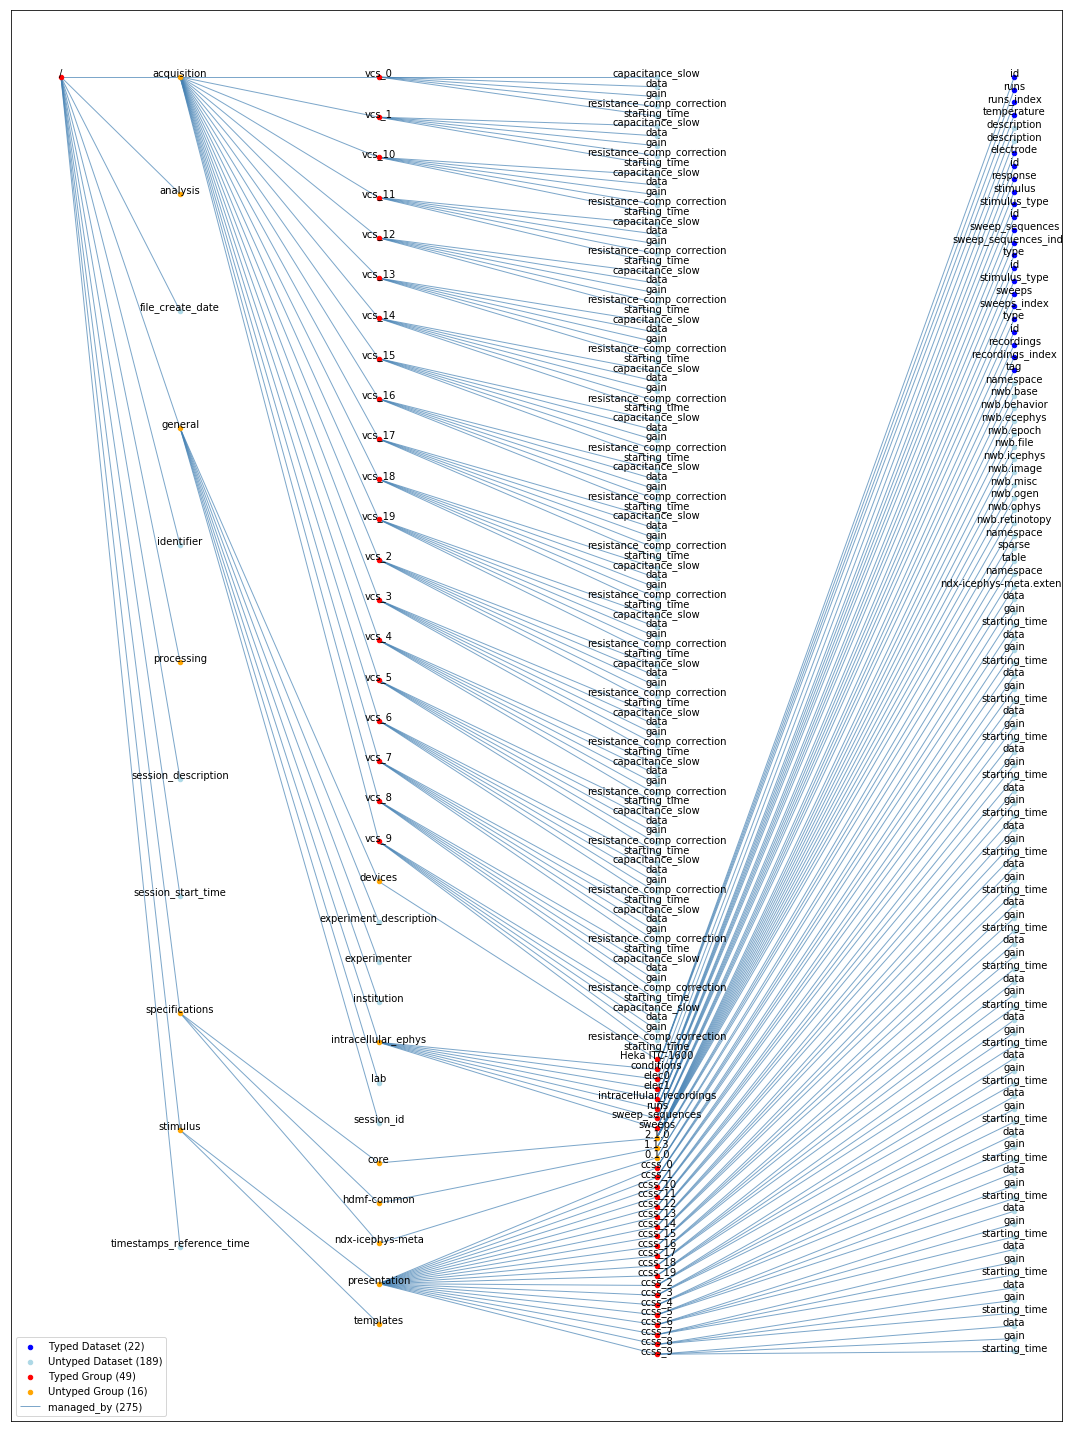

In [6]:
from nwb_docutils.doctools import render as docrender
h5hier = docrender.HierarchyDescription.from_hdf5(test_filename)
nxgraph = docrender.NXGraphHierarchyDescription(data=h5hier,
                                                include_attributes=False, # don't show attributes to clean up the plot
                                                include_groups=True,
                                                include_datasets=True,
                                                include_links=False
                                               )
fig = nxgraph.draw(figsize=(15,20),
                   label_offset=(0.0, 0.003),
                   label_font_size=10,

                   axis_on=True)

# 3. Do Common Queries

Here some common queries we identified

* Given a response, return the stimulus
* Given a stimulus, return the response
* Given a stimulus, return the stimulus type
* Given an electrode, return all sweeps recorded with it
* Given a stimulus type, return all derived stimuli 
* Get the list of all stimulus types 
* Given a stimulus type, get all the repetitions in which it is present [Enrico]
* Given a stimulus type and a repetition, get all the responses [Enrico]
* Given a stimulus or response, return all other stimuli and responses recorded during the same sweep* 
* Given a sweep, return its repetition
* Given a repetition, return all sweeps within that repetition
* Given a sweep or repetition, return its condition
* Given a condition, return all sweeps or repetitions
* Given a sweep, return all other sweeps of the same repetition
* Given a stimulus and a condition, return all sweeps across repetitions and average the responses

For query we can either: **(1)** interact with the DyanmicTables from PyNWB directly or using individual Pandas data tables (i.e, using the data in its normalized form, with data distrubted across the Conditions, Runs, SweepSequences, Sweeps, and IntracellularRecordings tables)  or we can **(2)** load all metadata (i.e., the DynamicTables but not the TimeSeries) and create a single denormalized dataframe that we can then use to implement the queries. In the following we first show to prepare data in Pandas DataFrames need for (2) and then afterwards we'll show how we can perform the various queries. 

# 3.1 Data Preparations

In Section 2.1 above we already showed how we can load the data into a hierarchical DataFrame. In this section we load all data into a single denormalized Pandas DataFrame to simplify query and show how we can expand compound data columns (i.e,. columns storing tuples in Pandas). 

In [7]:
icmeta = nwbfile.icephys_conditions.to_denormalized_dataframe()
print(nwbfile.icephys_conditions.name + " denormalized")
display(icmeta)

conditions denormalized


source_table conditions               runs      sweep_sequences  \
label                id temperature     id type              id   
0                100000        32.0  10000   R1            1000   
1                100000        32.0  10000   R1            1000   
2                100000        32.0  10000   R1            1000   
3                100000        32.0  10000   R1            1000   
4                100000        32.0  10001   R2            1001   
5                100000        32.0  10001   R2            1001   
6                100000        32.0  10001   R2            1001   
7                100000        32.0  10001   R2            1002   
8                100000        32.0  10001   R2            1002   
9                100000        32.0  10001   R2            1002   
10               100001        24.0  10002   R1            1003   
11               100001        24.0  10002   R1            1003   
12               100001        24.0  10002   R1            1003   
13               100001        24.0  10002   R1            1003   
14               100001        24.0  10003   R2            1004   
15               100001        24.0  10003   R2            1004   
16               100001        24.0  10003   R2            1004   
17               100001        24.0  10003   R2            1005   
18               100001        24.0  10003   R2            1005   
19               100001        24.0  10003   R2            1005   

source_table                      sweeps     intracellular_recordings  \
label          stimulus_type type     id tag                       id   
0             MyStimulusType   T1    100   0                        0   
1             MyStimulusType   T1    100   0                        1   
2             MyStimulusType   T1    101   1                        2   
3             MyStimulusType   T1    101   1                        3   
4             MyStimulusType   T2    102   2                        4   
5             MyStimulusType   T2    102   2                        5   
6             MyStimulusType   T2    102   2                        6   
7             MyStimulusType   T3    103   3                        7   
8             MyStimulusType   T3    103   3                        8   
9             MyStimulusType   T3    103   3                        9   
10            MyStimulusType   T1    104   4                       10   
11            MyStimulusType   T1    104   4                       11   
12            MyStimulusType   T1    105   5                       12   
13            MyStimulusType   T1    105   5                       13   
14            MyStimulusType   T2    106   6                       14   
15            MyStimulusType   T2    106   6                       15   
16            MyStimulusType   T2    106   6                       16   
17            MyStimulusType   T3    107   7                       17   
18            MyStimulusType   T3    107   7                       18   
19            MyStimulusType   T3    107   7                       19   

source_table                                                     \
label                                                  stimulus   
0             (0, 10, ccss_0 pynwb.icephys.VoltageClampStimu...   
1             (0, 10, ccss_1 pynwb.icephys.VoltageClampStimu...   
2             (0, 10, ccss_2 pynwb.icephys.VoltageClampStimu...   
3             (0, 10, ccss_3 pynwb.icephys.VoltageClampStimu...   
4             (0, 10, ccss_4 pynwb.icephys.VoltageClampStimu...   
5             (0, 10, ccss_5 pynwb.icephys.VoltageClampStimu...   
6             (0, 10, ccss_6 pynwb.icephys.VoltageClampStimu...   
7             (0, 10, ccss_7 pynwb.icephys.VoltageClampStimu...   
8             (0, 10, ccss_8 pynwb.icephys.VoltageClampStimu...   
9             (0, 10, ccss_9 pynwb.icephys.VoltageClampStimu...   
10            (0, 10, ccss_10 pynwb.icephys.VoltageClampStim...   
11            (0, 10, ccss_11 pynwb.icephys.Vol

Next we show how we can expand the tuples in the stimulus and response column to be separate columns instead.

In [8]:
stimulus_df = pd.DataFrame(icmeta.intracellular_recordings.stimulus.tolist(), 
                           columns=['start', 'count', 'stimulus']) 
response_df = pd.DataFrame(icmeta.intracellular_recordings.response.tolist(), 
                           columns=['start', 'count', 'response']) 
display(stimulus_df) # as an example we show the stimulus here, but the response looks very similar

,start,count,stimulus
0,0,10,ccss_0 pynwb.icephys.VoltageClampStimulusSerie...
1,0,10,ccss_1 pynwb.icephys.VoltageClampStimulusSerie...
2,0,10,ccss_2 pynwb.icephys.VoltageClampStimulusSerie...
3,0,10,ccss_3 pynwb.icephys.VoltageClampStimulusSerie...
4,0,10,ccss_4 pynwb.icephys.VoltageClampStimulusSerie...
5,0,10,ccss_5 pynwb.icephys.VoltageClampStimulusSerie...
6,0,10,ccss_6 pynwb.icephys.VoltageClampStimulusSerie...
7,0,10,ccss_7 pynwb.icephys.VoltageClampStimulusSerie...
8,0,10,ccss_8 pynwb.icephys.VoltageClampStimulusSerie...
9,0,10,ccss_9 pynwb.icephys.VoltageClampStimulusSerie...


Using the same approach we can also easily add details from the individual stimulus (and response) objects to our table by inspecting the objects, e.g., via

In [9]:
stimulus_df['name'] = [s.name for s in stimulus_df.stimulus]  # Add a column with the name of the stimulus object
stimulus_df['neurodata_type'] = [s.neurodata_type for s in stimulus_df.stimulus]  # Add a column with the name of the stimulus object
# We can do the same for any fields stored in our stimulus. Here we use a few of them
for field in ['gain', 'rate', 'starting_time']:
    stimulus_df[field] = [getattr(s, field) for s in stimulus_df.stimulus]  # Add a column with the gain from the stimulus 
display(stimulus_df)

,start,count,stimulus,name,neurodata_type,gain,rate,starting_time
0,0,10,ccss_0 pynwb.icephys.VoltageClampStimulusSerie...,ccss_0,VoltageClampStimulusSeries,0.213226,1000.0,39.556903
1,0,10,ccss_1 pynwb.icephys.VoltageClampStimulusSerie...,ccss_1,VoltageClampStimulusSeries,0.987908,8000.0,41.986931
2,0,10,ccss_2 pynwb.icephys.VoltageClampStimulusSerie...,ccss_2,VoltageClampStimulusSeries,0.596283,6000.0,46.475808
3,0,10,ccss_3 pynwb.icephys.VoltageClampStimulusSerie...,ccss_3,VoltageClampStimulusSeries,0.410961,3000.0,72.160194
4,0,10,ccss_4 pynwb.icephys.VoltageClampStimulusSerie...,ccss_4,VoltageClampStimulusSeries,0.070379,4000.0,97.853780
5,0,10,ccss_5 pynwb.icephys.VoltageClampStimulusSerie...,ccss_5,VoltageClampStimulusSeries,0.698615,5000.0,72.964434
6,0,10,ccss_6 pynwb.icephys.VoltageClampStimulusSerie...,ccss_6,VoltageClampStimulusSeries,0.776074,2000.0,86.039438
7,0,10,ccss_7 pynwb.icephys.VoltageClampStimulusSerie...,ccss_7,VoltageClampStimulusSeries,0.106349,8000.0,58.665418
8,0,10,ccss_8 pynwb.icephys.VoltageClampStimulusSerie...,ccss_8,VoltageClampStimulusSeries,0.319365,2000.0,26.607802
9,0,10,ccss_9 pynwb.icephys.VoltageClampStimulusSerie...,ccss_9,VoltageClampStimulusSeries,0.047339,2000.0,1.736548


We can naturally also go one step further and directly update our main data table directly to expand the stimulus and reponse columns and add further details from the stimulus and response directly to the table:

In [10]:
def add_stimulus_and_response_details(df, 
                                      expand_stimulus=True, 
                                      expand_response=True, 
                                      add_stimulus_name_and_type=True,
                                      add_stimulus_fields=None,
                                      add_response_name_and_type=True,
                                      add_response_fields=None
                                     ):
    if add_stimulus_fields is None:
        add_stimulus_fields = ['gain', 'rate', 'starting_time']
    if add_response_fields is None:
        add_response_fields = ['gain', 'rate', 'starting_time']
    stimulus_df = pd.DataFrame(df.intracellular_recordings.stimulus.tolist(), 
                               columns=['stimulus_start', 'stimulus_count', 'stimulus']) 
    response_df = pd.DataFrame(df.intracellular_recordings.response.tolist(), 
                               columns=['response_start', 'response_count', 'response']) 
    # Expand the stimulus column
    if expand_stimulus:
        for i in stimulus_df.columns:
            df.loc[:,('intracellular_recordings', i)] = stimulus_df.loc[:, i]
    # Expand the response column
    if expand_response:
        for i in response_df.columns:
            df.loc[:,('intracellular_recordings', i)] = response_df.loc[:, i]
    # Add details from the stimulus
    if add_stimulus_name_and_type:
        df.loc[:,('intracellular_recordings', 'stimulus_name')] = [s.name for s in stimulus_df.stimulus]
        df.loc[:,('intracellular_recordings', 'stimulus_neurodata_type')] = [s.neurodata_type for s in stimulus_df.stimulus]
    if len(add_stimulus_fields) > 0:
        for field in add_stimulus_fields:
            df.loc[:,('intracellular_recordings', 'stimulus_' + field )] = [getattr(s, field, None) for s in stimulus_df.stimulus]  
    # Add details from the response
    if add_response_name_and_type:
        df.loc[:,('intracellular_recordings', 'response_name')] = [r.name for r in response_df.response]
        df.loc[:,('intracellular_recordings', 'response_neurodata_type')] = [r.neurodata_type for r in response_df.response]
    if len(add_response_fields) > 0:
        for field in add_response_fields:
            df.loc[:,('intracellular_recordings', 'response_' + field )] = [getattr(r, field, None) for r in response_df.response]  
    
    
    # Add details from the reponse
    return df
    
# Expand the dataframe and display. Here we do this on a copy of the DataFrame as we'll use the regular DataFrame below for our example queries
display(add_stimulus_and_response_details(icmeta.copy()))

source_table conditions               runs      sweep_sequences  \
label                id temperature     id type              id   
0                100000        32.0  10000   R1            1000   
1                100000        32.0  10000   R1            1000   
2                100000        32.0  10000   R1            1000   
3                100000        32.0  10000   R1            1000   
4                100000        32.0  10001   R2            1001   
5                100000        32.0  10001   R2            1001   
6                100000        32.0  10001   R2            1001   
7                100000        32.0  10001   R2            1002   
8                100000        32.0  10001   R2            1002   
9                100000        32.0  10001   R2            1002   
10               100001        24.0  10002   R1            1003   
11               100001        24.0  10002   R1            1003   
12               100001        24.0  10002   R1            1003   
13               100001        24.0  10002   R1            1003   
14               100001        24.0  10003   R2            1004   
15               100001        24.0  10003   R2            1004   
16               100001        24.0  10003   R2            1004   
17               100001        24.0  10003   R2            1005   
18               100001        24.0  10003   R2            1005   
19               100001        24.0  10003   R2            1005   

source_table                      sweeps     intracellular_recordings  ...  \
label          stimulus_type type     id tag                       id  ...   
0             MyStimulusType   T1    100   0                        0  ...   
1             MyStimulusType   T1    100   0                        1  ...   
2             MyStimulusType   T1    101   1                        2  ...   
3             MyStimulusType   T1    101   1                        3  ...   
4             MyStimulusType   T2    102   2                        4  ...   
5             MyStimulusType   T2    102   2                        5  ...   
6             MyStimulusType   T2    102   2                        6  ...   
7             MyStimulusType   T3    103   3                        7  ...   
8             MyStimulusType   T3    103   3                        8  ...   
9             MyStimulusType   T3    103   3                        9  ...   
10            MyStimulusType   T1    104   4                       10  ...   
11            MyStimulusType   T1    104   4                       11  ...   
12            MyStimulusType   T1    105   5                       12  ...   
13            MyStimulusType   T1    105   5                       13  ...   
14            MyStimulusType   T2    106   6                       14  ...   
15            MyStimulusType   T2    106   6                       15  ...   
16            MyStimulusType   T2    106   6                       16  ...   
17            MyStimulusType   T3    107   7                       17  ...   
18            MyStimulusType   T3    107   7                       18  ...   
19            MyStimulusType   T3    107   7                       19  ...   

source_table                                                          \
label        stimulus_name     stimulus_neurodata_type stimulus_gain   
0                   ccss_0  VoltageClampStimulusSeries      0.213226   
1                   ccss_1  VoltageClampStimulusSeries      0.987908   
2                   ccss_2  VoltageClampStimulusSeries      0.596283   
3                   ccss_3  VoltageClampStimulusSeries      0.410961   
4                   ccss_4  VoltageClampStimulusSeries      0.070379   
5                   ccss_5  VoltageClampStimulusSeries      0.698615   
6                   ccss_6  VoltageClampStimulusSeries      0.776074   
7                   ccss_7  VoltageClampStimulusSeries      0.106349   
8                   ccss_8  VoltageClampStimulusSeries      0.319365   
9               

## Query 1: Given a stimulus type, return all derived stimuli

**Example 1:** Using the custom stimulus type column 

In [11]:
icmeta[ icmeta.intracellular_recordings.stimulus_type == 'A2' ]

source_table conditions               runs      sweep_sequences  \
label                id temperature     id type              id   
1                100000        32.0  10000   R1            1000   
11               100001        24.0  10002   R1            1003   

source_table                      sweeps     intracellular_recordings  \
label          stimulus_type type     id tag                       id   
1             MyStimulusType   T1    100   0                        1   
11            MyStimulusType   T1    104   4                       11   

source_table                                                     \
label                                                  stimulus   
1             (0, 10, ccss_1 pynwb.icephys.VoltageClampStimu...   
11            (0, 10, ccss_11 pynwb.icephys.VoltageClampStim...   

source_table                                                     \
label                                                  response   
1             (0, 10, vcs_1 pynwb.icephys.VoltageClampSeries...   
11            (0, 10, vcs_11 pynwb.icephys.VoltageClampSerie...   

source_table                                                                   
label                                                 electrode stimulus_type  
1             elec1 pynwb.icephys.IntracellularElectrode at ...            A2  
11            elec1 pynwb.icephys.IntracellularElectrode at ...            A2

**Example 2:** Based on the neurodata_type of the stimulus.

In [12]:
stimulus_df['neurodata_type'] == 'CurrentClampStimulusSeries'

0     False
1     False
2     False
3     False
4     False
5     False
6     False
7     False
8     False
9     False
10    False
11    False
12    False
13    False
14    False
15    False
16    False
17    False
18    False
19    False
Name: neurodata_type, dtype: bool

## Query 2: Get the list of all stimulus types 

In [13]:
unique_stimulus_types = np.unique(icmeta.intracellular_recordings.stimulus_type)
print(unique_stimulus_types)

['A1' 'A2' 'B1' 'B2' 'C1' 'C2' 'C3' 'D1' 'D2' 'D3']
